In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Create a simple LSTM model for MIDI sequence prediction
class MidiLSTM(nn.Module):
    """
    vocab_size: Size of the vocabulary (number of unique MIDI tokens)
    embed_size: Size of the embedding vector for each token
    hidden_size: Size of the hidden state in the LSTM
    num_layers: Number of LSTM layers
    dropout: Dropout rate applied to the LSTM outputs

    """
    def __init__(self, vocab_size = 282, embed_size = 64, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size) # Each token is mapped to an embedding vector so that model can learn relationships between tokens
        self.lstm = nn.LSTM(input_size = embed_size, hidden_size = hidden_size, num_layers = num_layers,
                            dropout=dropout, batch_first=True) # Initializes a multi-layer LSTM
        self.fc = nn.Linear(hidden_size, vocab_size) # Fully connected layer to map LSTM output to vocabulary size; predicts the next token in the sequence

    def forward(self, x):
        x = self.embedding(x)            # Converts tokens to vectors: [B, seq_len] → [B, seq_len, embed]
        out, _ = self.lstm(x)            # out: [B, seq_len, hidden]
        # _ is the hidden state and cell state, which we ignore here
        logits = self.fc(out[:, -1, :])  # last timestep → [B, vocab]
        return logits

In [3]:
#Pick a manual seed for randomisation
torch.manual_seed(42)
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Create an instance of the model on the device
model = MidiLSTM().to(device)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import dataset
from dataset import MIDIDataset
from glob import glob
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from importlib import reload
# Reload the dataset module to ensure it is up-to-date
reload(dataset)

# Step 1: Load MIDI files
midi_files = glob('CSD_dataset/**/*.mid', recursive=True)

# Step 2: Split the dataset into training and testing sets
train_files, test_files = train_test_split(midi_files, test_size=0.2, random_state=42)

# Step 3: Create dataset objects
train_dataset = MIDIDataset(train_files)
test_dataset = MIDIDataset(test_files)
    
dataset = MIDIDataset(midi_paths=midi_files)

print(len(dataset))
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
for i, (x, y) in enumerate(dataloader):
    if i < 2:  # Just to limit the output for demonstration
        print(f"Batch {i+1}:")
        print(f"x: {x}")
        print(f"y: {y}")

Adding CSD_dataset\korean\mid\kr043a.mid to dataset...
Adding CSD_dataset\english\mid\en020a.mid to dataset...
Adding CSD_dataset\english\mid\en013a.mid to dataset...
Adding CSD_dataset\korean\mid\kr022b.mid to dataset...
Adding CSD_dataset\korean\mid\kr022a.mid to dataset...
Adding CSD_dataset\english\mid\en015b.mid to dataset...
Adding CSD_dataset\english\mid\en010b.mid to dataset...
Adding CSD_dataset\korean\mid\kr036a.mid to dataset...
Adding CSD_dataset\korean\mid\kr015a.mid to dataset...
Adding CSD_dataset\korean\mid\kr010b.mid to dataset...
Adding CSD_dataset\english\mid\en029a.mid to dataset...
Adding CSD_dataset\english\mid\en003b.mid to dataset...
Adding CSD_dataset\korean\mid\kr012b.mid to dataset...
Adding CSD_dataset\korean\mid\kr008a.mid to dataset...
Adding CSD_dataset\english\mid\en047b.mid to dataset...
Adding CSD_dataset\korean\mid\kr021a.mid to dataset...
Adding CSD_dataset\english\mid\en048b.mid to dataset...
Adding CSD_dataset\korean\mid\kr037a.mid to dataset...
Ad

In [6]:
import random

In [7]:
# Convert the data to PyTorch tensors
#X_train, y_train = train_dataset.split_X_y()
#X_test, y_test = test_dataset.split_X_y()

In [8]:
#print(X_train.shape)  # should be: [batch_size, seq_len]
#print(X_test.shape)   # should be: [batch_size, seq_len]
#print(y_train.shape)  # should be: [batch_size]
#print(y_test.shape)   # should be: [batch_size]

In [9]:
# Send the data to the device (GPU or CPU) to allow for parallel processing
#X_test = X_test.to(device)
#y_test = y_test.to(device)
#X_train = X_train.to(device)
#y_train = y_train.to(device)

In [10]:
# Set the criterion of the model to measure the error
criterion = nn.CrossEntropyLoss()

# Set the optimizer to update the model parameters; Set learning rate and weight decay (to prevent overfitting)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

In [11]:
model.parameters

<bound method Module.parameters of MidiLSTM(
  (embedding): Embedding(282, 64)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=282, bias=True)
)>

In [12]:
model = model.to(device)  # Move the model to the device (GPU or CPU)

# Train model
model.train()  # Set the model to training mode

epochs = 30
batches = epochs * len(train_dataset) // 8  # Total number of batches
losses = []
avg_losses = []
train_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
for epoch in range(epochs):
    # Train the model in batches using the DataLoader
    print(f'Starting epoch {epoch + 1}/{epochs}...')
    for i, (batch_x, batch_y) in enumerate(train_loader):
        # Move data to the device
        x = batch_x.to(device)
        y = batch_y.to(device)

        outputs = model(x)  # Forward pass
        loss = criterion(outputs, y)  # Compute the loss
          # Move loss to CPU for plotting
        losses.append(loss.item())  # Store loss for plotting
        
        
        # Backpropagation and optimization
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
    # Print average loss for each epoch
    avg_loss = sum(losses) / len(losses)
    avg_losses.append(avg_loss)  # Store average loss for plotting
    print(f'Epoch [{epoch + 1}/{epochs}], Average Loss: {avg_loss:.4f}')

Starting epoch 1/30...
Epoch [1/30], Average Loss: 1.8810
Starting epoch 2/30...
Epoch [2/30], Average Loss: 1.6434
Starting epoch 3/30...
Epoch [3/30], Average Loss: 1.5150
Starting epoch 4/30...
Epoch [4/30], Average Loss: 1.4354
Starting epoch 5/30...
Epoch [5/30], Average Loss: 1.3832
Starting epoch 6/30...
Epoch [6/30], Average Loss: 1.3483
Starting epoch 7/30...
Epoch [7/30], Average Loss: 1.3138
Starting epoch 8/30...
Epoch [8/30], Average Loss: 1.2883
Starting epoch 9/30...
Epoch [9/30], Average Loss: 1.2651
Starting epoch 10/30...
Epoch [10/30], Average Loss: 1.2444
Starting epoch 11/30...
Epoch [11/30], Average Loss: 1.2261
Starting epoch 12/30...
Epoch [12/30], Average Loss: 1.2164
Starting epoch 13/30...
Epoch [13/30], Average Loss: 1.2390
Starting epoch 14/30...
Epoch [14/30], Average Loss: 1.2733
Starting epoch 15/30...
Epoch [15/30], Average Loss: 1.2762
Starting epoch 16/30...
Epoch [16/30], Average Loss: 1.2717
Starting epoch 17/30...
Epoch [17/30], Average Loss: 1.264

[1.8810029961978612, 1.6434236628299965, 1.515004071740089, 1.4353601553310167, 1.38320839001971, 1.3482615255942458, 1.3137619477717304, 1.2882785667600023, 1.2651426800906524, 1.24435281647876, 1.2261154274913635, 1.2163831562333343, 1.2390363623126837, 1.273306534775522, 1.2761975522395637, 1.2717013436119797, 1.2640308320429274, 1.2550994776277722, 1.2463379857091612, 1.2368957566905103, 1.2283706409752533, 1.2283085363678383, 1.2226704431890874, 1.2138762918108992, 1.2273738551611357, 1.2368034432941095, 1.2328833882403782, 1.225927422610864, 1.219273355130777, 1.2121270312044699]


Text(0, 0.5, 'Loss')

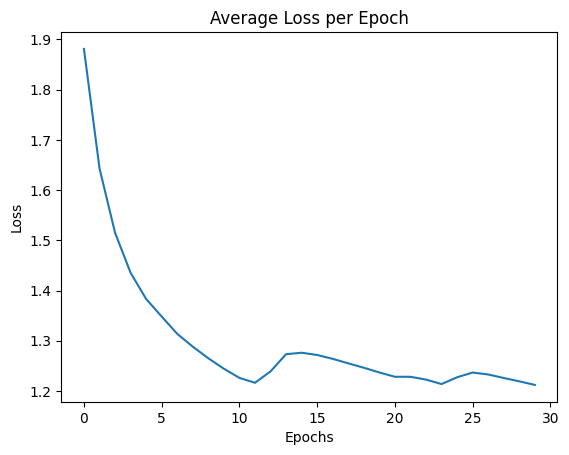

In [13]:
print(avg_losses)
epoch_range = range(epochs)
plt.title('Average Loss per Epoch')
plt.plot(epoch_range, avg_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

5.585277557373047


Text(0, 0.5, 'Loss')

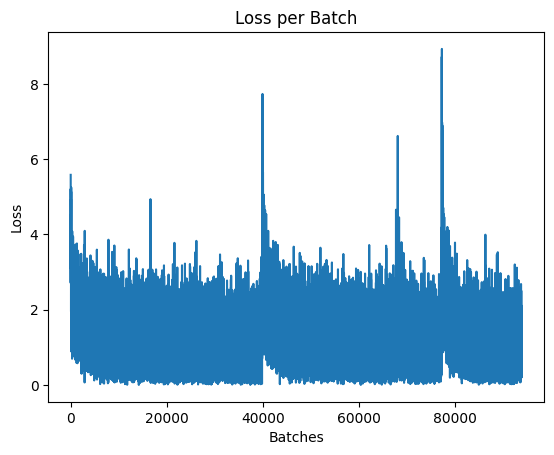

In [14]:
print(losses[0])
batch_range = range(len(losses))
plt.title('Loss per Batch')
plt.plot(batch_range, losses)
plt.xlabel('Batches')
plt.ylabel('Loss')

In [15]:
# Evaluate model on Test Data set
example_tensor = torch.tensor([ 42, 117, 129,   4, 189,  47, 117, 144, 209,  43, 117, 128, 213,  47,
         117, 128, 217,  50, 117, 128,   4, 189,  49, 117, 147,   4, 189,  52,
         117, 144, 209,  51, 117, 128, 213,  52, 117, 128, 217,  54, 117, 128,
           4, 189,  55, 117, 132, 197,  52, 117, 132, 205,  49, 117, 128, 209,
          45, 117, 129,   4, 189,  49, 117, 130], dtype= torch.long).unsqueeze(0).to(device)  # Example tensor to evaluate

y_answer = torch.tensor([177], dtype=torch.long).to(device)  # Expected output tensor for evaluation
with torch.no_grad(): # Disable backpropagation
    y_eval = model()  # Forward pass on test data
    loss = criterion(y_eval, y_answer)  # Compute the loss on test data
    print(f'Evaluation Loss: {loss.item():.4f}')  # Print the evaluation loss
    

TypeError: MidiLSTM.forward() missing 1 required positional argument: 'x'

In [16]:
correct = 0
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(train_dataset):
        print(f'Evaluating sample {i + 1}/{len(train_dataset)}...')
        x_batch = x_batch.unsqueeze(0).to(device)
        y_batch = y_batch.unsqueeze(0).to(device)
        y_eval = model(x_batch)  # Forward pass for each sample

        # Verify if the prediction is correct
        if y_eval.argmax(dim = 1) == y_batch:
            correct += 1
print(f'Accuracy: {correct / len(train_dataset) * 100:.2f}%')
print(f'Total correct predictions: {correct} out of {len(train_dataset)}')

Evaluating sample 1/90304...
Evaluating sample 2/90304...
Evaluating sample 3/90304...
Evaluating sample 4/90304...
Evaluating sample 5/90304...
Evaluating sample 6/90304...
Evaluating sample 7/90304...
Evaluating sample 8/90304...
Evaluating sample 9/90304...
Evaluating sample 10/90304...
Evaluating sample 11/90304...
Evaluating sample 12/90304...
Evaluating sample 13/90304...
Evaluating sample 14/90304...
Evaluating sample 15/90304...
Evaluating sample 16/90304...
Evaluating sample 17/90304...
Evaluating sample 18/90304...
Evaluating sample 19/90304...
Evaluating sample 20/90304...
Evaluating sample 21/90304...
Evaluating sample 22/90304...
Evaluating sample 23/90304...
Evaluating sample 24/90304...
Evaluating sample 25/90304...
Evaluating sample 26/90304...
Evaluating sample 27/90304...
Evaluating sample 28/90304...
Evaluating sample 29/90304...
Evaluating sample 30/90304...
Evaluating sample 31/90304...
Evaluating sample 32/90304...
Evaluating sample 33/90304...
Evaluating sample 3

In [45]:
new_seq = [ 42, 117, 129,   4, 189,  47, 117, 144, 209,  43, 117, 128, 213,  47,
         117, 128, 217,  50, 117, 128,   4, 189,  49, 117, 147,   4, 189,  52,
         117, 144, 209,  51, 117, 128, 213,  52, 117, 128, 217,  54, 117, 128,
           4, 189,  55, 117, 132, 197,  52, 117, 132, 205,  49, 117, 128, 209,
          45, 117, 129,   4, 189,  49, 117, 130] # Example input for prediction
new_seq_tensor = torch.tensor(new_seq, dtype=torch.long).unsqueeze(0).to(device)  # Convert to tensor and add batch dimension

In [50]:
with torch.no_grad():
    for i in range(100):  # Predict the next 10 tokens
        prediction = model(new_seq_tensor.to(device)).argmax().item()

        print(f'{prediction}')
        new_seq.append(prediction)
        new_seq_tensor = torch.tensor(new_seq, dtype=torch.long).unsqueeze(0).to(device)
    print(f'Updated input tensor: {new_seq}')

47
117
128
201
42
117
128
205
42
117
128
209
42
117
128
4
189
42
117
128
193
47
117
128
197
47
117
128
201
42
117
128
213
42
117
128
217
42
117
128
4
189
42
117
128
193
47
117
128
197
47
117
128
201
42
117
128
205
47
117
128
209
47
117
128
213
47
117
128
217
42
117
128
4
189
47
117
128
193
47
117
128
197
47
117
128
201
42
117
128
205
42
117
128
209
42
117
128
4
189
Updated input tensor: [42, 117, 129, 4, 189, 47, 117, 144, 209, 43, 117, 128, 213, 47, 117, 128, 217, 50, 117, 128, 4, 189, 49, 117, 147, 4, 189, 52, 117, 144, 209, 51, 117, 128, 213, 52, 117, 128, 217, 54, 117, 128, 4, 189, 55, 117, 132, 197, 52, 117, 132, 205, 49, 117, 128, 209, 45, 117, 129, 4, 189, 49, 117, 130, 197, 47, 117, 128, 201, 47, 117, 128, 205, 47, 117, 128, 209, 47, 117, 128, 213, 42, 117, 128, 217, 47, 117, 128, 4, 189, 47, 117, 128, 193, 47, 117, 128, 197, 47, 117, 128, 201, 42, 117, 128, 205, 44, 117, 128, 209, 42, 117, 128, 213, 42, 117, 128, 217, 47, 117, 128, 4, 189, 47, 117, 128, 193, 47, 117, 128, 197,

In [54]:
import tokenizer
from tokenizer import MidiTokenizer
from importlib import reload
reload(tokenizer)
# Initialize the tokenizer
tokenize = MidiTokenizer()
tokenized_file = tokenize.tokenize_file('CSD_dataset/english/mid/en001a.mid')
tts = tokenize.tokens_to_string(tokenized_file)  # Example usage to convert tokens to MIDI file
print(f'Tokens to string: {tts}')
midi_file = tokenize.tokens_to_midi(tokenized_file)  # Example usage to convert MIDI file to tokens

Tokens to string: ['Bar_None', 'Bar_None', 'Position_0', 'Pitch_61', 'Velocity_99', 'Duration_0.6.8', 'Position_8', 'Pitch_61', 'Velocity_99', 'Duration_1.0.8', 'Position_16', 'Pitch_68', 'Velocity_99', 'Duration_0.7.8', 'Position_24', 'Pitch_68', 'Velocity_99', 'Duration_0.6.8', 'Bar_None', 'Position_0', 'Pitch_70', 'Velocity_99', 'Duration_0.6.8', 'Position_8', 'Pitch_70', 'Velocity_99', 'Duration_0.5.8', 'Position_16', 'Pitch_68', 'Velocity_99', 'Duration_1.0.8', 'Position_31', 'Pitch_66', 'Velocity_99', 'Duration_0.6.8', 'Bar_None', 'Position_8', 'Pitch_66', 'Velocity_99', 'Duration_0.6.8', 'Position_15', 'Pitch_65', 'Velocity_99', 'Duration_0.6.8', 'Position_24', 'Pitch_65', 'Velocity_99', 'Duration_0.4.8', 'Position_31', 'Pitch_63', 'Velocity_99', 'Duration_0.5.8', 'Bar_None', 'Position_4', 'Pitch_63', 'Velocity_99', 'Duration_0.5.8', 'Position_8', 'Pitch_63', 'Velocity_99', 'Duration_0.4.8', 'Position_12', 'Pitch_63', 'Velocity_99', 'Duration_0.2.8', 'Position_16', 'Pitch_61', '

c:\Users\rober\OneDrive\Documents\0.School\WILLIAM PERKIN\Comp\1. NEA project prototype\.venv\Lib\site-packages\miditok\midi_tokenizer.py:1940: UserWarning: The input sequence has one dimension less than expected (1 instead of 2). It is being unsqueezed to conform with the tokenizer's i/o format (('I', 'T'))
  tokens = self._convert_sequence_to_tokseq(tokens)


KeyError: (0, 4)

In [30]:
# Save netural network model
torch.save(model.state_dict(), 'MIDI_lstm_model_V1.pt')

In [31]:
new_model = MidiLSTM()
new_model.load_state_dict(torch.load('MIDI_lstm_model_V1.pt'))

<All keys matched successfully>

In [32]:
new_model.eval()

MidiLSTM(
  (embedding): Embedding(282, 64)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=282, bias=True)
)